In [19]:
from __future__ import division
import sys
import random
import copy
import math
import json

import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns

from anndata import AnnData
import scanpy as sc

# Load Smart-seq2 data

In [33]:
adata = sc.read_h5ad("../data/adata_aging_glia.h5ad")
adata

AnnData object with n_obs × n_vars = 1883 × 14179
    obs: 'cell_type', 'tissue', 'plate', 'reads', 'sex', 'age'

In [34]:
adata.obs["cell_type"].value_counts()

50d_repo_glia           569
50d_ensheathing_glia    558
5d_ensheathing_glia     470
5d_repo_glia            286
Name: cell_type, dtype: int64

# remove below

In [26]:
df_libs = pd.read_csv("../data/lib_run52_new.csv", sep=",", header=0, index_col=0) # sample info

In [27]:
cells = df_libs.index

In [28]:
df_libs_sub = df_libs.loc[adata.obs_names]

In [29]:
df_libs_sub

num_mapped_reads  genotype  \
50d_ensheathing_glia_P1_A10           15975.0       NaN   
50d_ensheathing_glia_P1_A11           16750.0       NaN   
50d_ensheathing_glia_P1_A14           46805.0       NaN   
50d_ensheathing_glia_P1_A15          169952.0       NaN   
50d_ensheathing_glia_P1_A16          111959.0       NaN   
...                                       ...       ...   
5d_repo_glia_P2_O20                  121651.0       NaN   
5d_repo_glia_P2_O24                   43413.0       NaN   
5d_repo_glia_P2_P10                  148965.0       NaN   
5d_repo_glia_P2_P11                   13729.0       NaN   
5d_repo_glia_P2_P13                   56439.0       NaN   

                                               plate  sex tissue  \
50d_ensheathing_glia_P1_A10  50d_ensheathing_glia_P1  mix   glia   
50d_ensheathing_glia_P1_A11  50d_ensheathing_glia_P1  mix   glia   
50d_ensheathing_glia_P1_A14  50d_ensheathing_glia_P1  mix   glia   
50d_ensheathing_glia_P1_A15  50d_ensheathing_glia_P1  mix   glia   
50d_ensheathing_glia_P1_A16  50d_ensheathing_glia_P1  mix   glia   
...                                              ...  ...    ...   
5d_repo_glia_P2_O20                  5d_repo_glia_P2  mix   glia   
5d_repo_glia_P2_O24                  5d_repo_glia_P2  mix   glia   
5d_repo_glia_P2_P10                  5d_repo_glia_P2  mix   glia   
5d_repo_glia_P2_P11                  5d_repo_glia_P2  mix   glia   
5d_repo_glia_P2_P13                  5d_repo_glia_P2  mix   glia   

                                            label  age    color  
50d_ensheathing_glia_P1_A10  50d_ensheathing_glia  50d  #FFFFCC  
50d_ensheathing_glia_P1_A11  50d_ensheathing_glia  50d  #FFFFCC  
50d_ensheathing_glia_P1_A14  50d_ensheathing_glia  50d  #FFFFCC  
50d_ensheathing_glia_P1_A15  50d_ensheathing_glia  50d  #FFFFCC  
50d_ensheathing_glia_P1_A16  50d_ensheathing_glia  50d  #FFFFCC  
...                                           ...  ...      ...  
5d_repo_glia_P2_O20                  5d_repo_glia   5d  #CCCCCC  
5d_repo_glia_P2_O24                  5d_repo_glia   5d  #CCCCCC  
5d_repo_glia_P2_P10                  5d_repo_glia   5d  #CCCCCC  
5d_repo_glia_P2_P11                  5d_repo_glia   5d  #CCCCCC  
5d_repo_glia_P2_P13                  5d_repo_glia   5d  #CCCCCC  

[1883 rows x 8 columns]

In [30]:
adata.obs["age"] = pd.Categorical(df_libs_sub["age"].values)

In [31]:
adata

AnnData object with n_obs × n_vars = 1883 × 14179
    obs: 'cell_type', 'tissue', 'plate', 'reads', 'sex', 'age'

In [32]:
#adata.write("../data/adata_aging_glia.h5ad")

In [35]:
#select repo glia and entheathing glia
adata_repo_glia_Y = adata[adata.obs["cell_type"]=="5d_repo_glia"]
adata_repo_glia_O = adata[adata.obs["cell_type"]=="50d_repo_glia"]
adata_repo_glia = adata_repo_glia_Y.concatenate(adata_repo_glia_O,
                                                  batch_categories=['repo_glia_5d',
                                                                    'repo_glia_50d'])

adata_repo_glia

/Users/hongjieli/anaconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 855 × 14179
    obs: 'cell_type', 'tissue', 'plate', 'reads', 'sex', 'age', 'batch'

In [36]:
adata_en_glia_Y = adata[adata.obs["cell_type"]=="5d_ensheathing_glia"]
adata_en_glia_O = adata[adata.obs["cell_type"]=="50d_ensheathing_glia"]
adata_en_glia = adata_en_glia_Y.concatenate(adata_en_glia_O,
                                                  batch_categories=['Ensheathing_glia_5d',
                                                                    'Ensheathing_glia_50d'])
adata_en_glia

AnnData object with n_obs × n_vars = 1028 × 14179
    obs: 'cell_type', 'tissue', 'plate', 'reads', 'sex', 'age', 'batch'

In [37]:
#select repo glia and entheathing glia
adata_glia = adata_repo_glia.concatenate(adata_en_glia,batch_categories=['repo_glia','ensheathing_glia'])

adata_glia

AnnData object with n_obs × n_vars = 1883 × 14179
    obs: 'cell_type', 'tissue', 'plate', 'reads', 'sex', 'age', 'batch'

In [38]:
#calculate PCA, and reduce dimensionality using umap and tNSE

sc.tl.pca(adata_glia, svd_solver='arpack')

sc.pp.neighbors(adata_glia, n_neighbors=15, n_pcs=50)

sc.tl.umap(adata_glia)
sc.tl.tsne(adata_glia)

sc.tl.louvain(adata_glia)

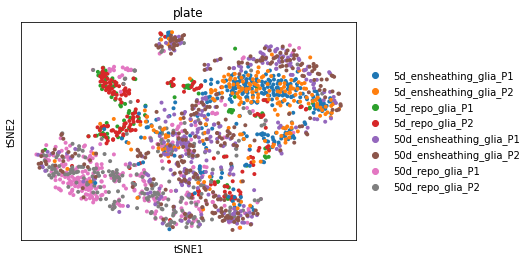

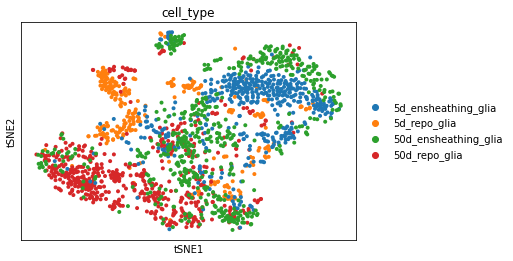

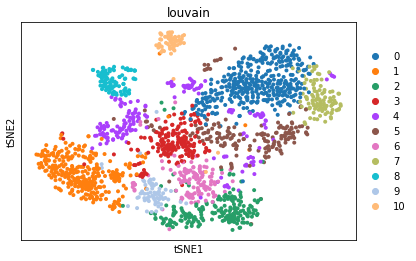

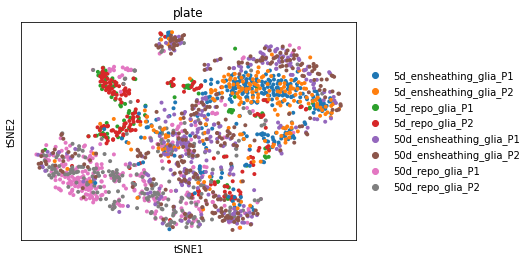

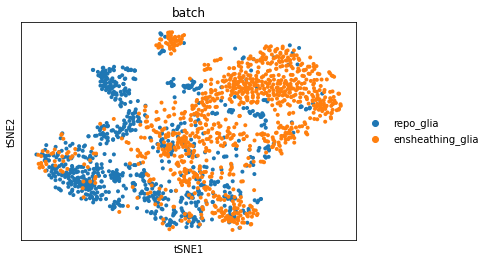

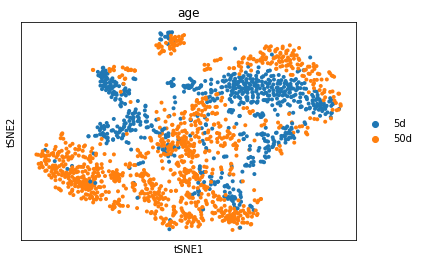

In [40]:
# data visuliation
sc.pl.tsne(adata_glia, color="plate")
sc.pl.tsne(adata_glia, color="cell_type")
sc.pl.tsne(adata_glia, color="louvain")
sc.pl.tsne(adata_glia, color="plate")
sc.pl.tsne(adata_glia, color="batch")
sc.pl.tsne(adata_glia, color="age")

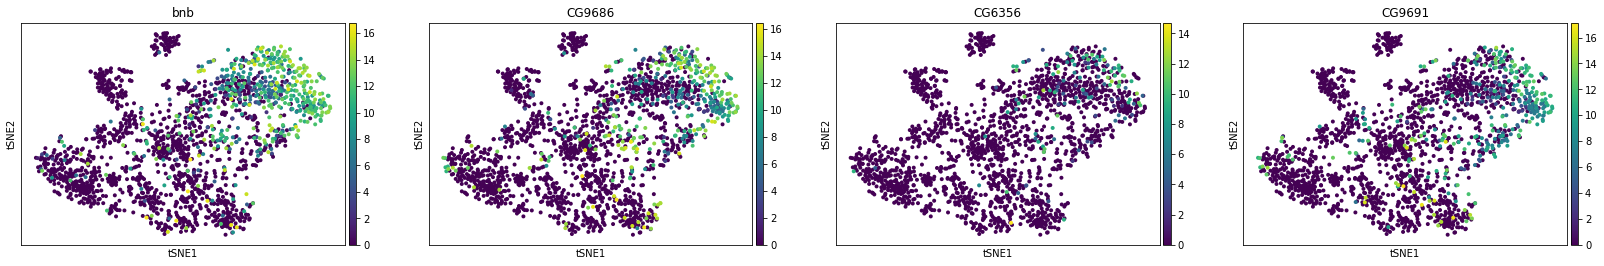

In [42]:
# validate using ensheathing glia markers
sc.pl.tsne(adata_glia, color=["bnb","CG9686","CG6356","CG9691"])

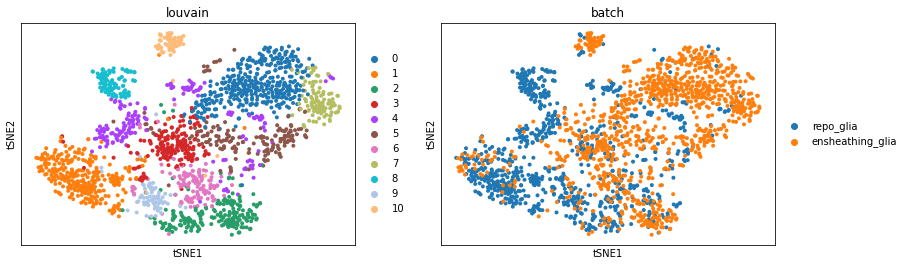

In [44]:
sc.pl.tsne(adata_glia, color=["louvain","batch"])

In [46]:
#manually curate repo+ non-ensheathing glia
adata_repo_glia_nonEn = adata_glia[(adata_glia.obs["louvain"]=="1") | 
                                   (adata_glia.obs["louvain"]=="4")|
                                   (adata_glia.obs["louvain"]=="8")|
                                   (adata_glia.obs["louvain"]=="9")]

adata_repo_glia_nonEn = adata_repo_glia_nonEn[(adata_repo_glia_nonEn.obs["batch"]=="repo_glia")]
adata_repo_glia_nonEn_5d = adata_repo_glia_nonEn[(adata_repo_glia_nonEn.obs["plate"]=="5d_repo_glia_P1")|
                                                (adata_repo_glia_nonEn.obs["plate"]=="5d_repo_glia_P2")]

adata_repo_glia_nonEn_50d = adata_repo_glia_nonEn[(adata_repo_glia_nonEn.obs["plate"]=="50d_repo_glia_P1")|
                                                (adata_repo_glia_nonEn.obs["plate"]=="50d_repo_glia_P2")]
adata_repo_glia_nonEn

View of AnnData object with n_obs × n_vars = 554 × 14179
    obs: 'cell_type', 'tissue', 'plate', 'reads', 'sex', 'age', 'batch', 'louvain'
    uns: 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'plate_colors', 'cell_type_colors', 'batch_colors', 'age_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [47]:
#manually curate clean ensheathing glia
adata_en_glia_nonRepo = adata_glia[(adata_glia.obs["louvain"]=="0") | 
                                   (adata_glia.obs["louvain"]=="2")|
                                   (adata_glia.obs["louvain"]=="3")|
                                   (adata_glia.obs["louvain"]=="5")|
                                   (adata_glia.obs["louvain"]=="6")|
                                   (adata_glia.obs["louvain"]=="7")|
                                   (adata_glia.obs["louvain"]=="10")]

adata_en_glia_nonRepo = adata_en_glia_nonRepo[(adata_en_glia_nonRepo.obs["batch"]=="ensheathing_glia")]

adata_en_glia_nonRepo_5d = adata_en_glia_nonRepo[(adata_en_glia_nonRepo.obs["plate"]=="5d_ensheathing_glia_P1")|
                                                (adata_en_glia_nonRepo.obs["plate"]=="5d_ensheathing_glia_P2")]

adata_en_glia_nonRepo_50d = adata_en_glia_nonRepo[(adata_en_glia_nonRepo.obs["plate"]=="50d_ensheathing_glia_P1")|
                                                (adata_en_glia_nonRepo.obs["plate"]=="50d_ensheathing_glia_P2")]

adata_en_glia_nonRepo

View of AnnData object with n_obs × n_vars = 933 × 14179
    obs: 'cell_type', 'tissue', 'plate', 'reads', 'sex', 'age', 'batch', 'louvain'
    uns: 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'plate_colors', 'cell_type_colors', 'batch_colors', 'age_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [49]:
a = adata_repo_glia_nonEn.obs.index
a1 = adata_repo_glia_nonEn_5d.obs.index
a2 = adata_repo_glia_nonEn_50d.obs.index
print ("non_ensheathing", len(a))
print ("non_ensheathing_5d", len(a1))
print ("non_ensheathing_50d", len(a2))


b = adata_en_glia_nonRepo.obs.index
b1 = adata_en_glia_nonRepo_5d.obs.index
b2 = adata_en_glia_nonRepo_50d.obs.index


print ("ensheathing", len(b))
print ("ensheathing_5d", len(b1))
print ("ensheathing_50d", len(b2))

non_ensheathing 554
non_ensheathing_5d 223
non_ensheathing_50d 331
ensheathing 933
ensheathing_5d 443
ensheathing_50d 490


In [50]:
adata_glia_clean = adata_repo_glia_nonEn.concatenate(adata_en_glia_nonRepo,batch_categories=['repo_glia_filter',
                                                                                             'ensheathing_glia_filter'])
adata_glia_clean

AnnData object with n_obs × n_vars = 1487 × 14179
    obs: 'cell_type', 'tissue', 'plate', 'reads', 'sex', 'age', 'batch', 'louvain'
    obsm: 'X_pca', 'X_umap', 'X_tsne'

In [51]:
# clustering analysis of clean glia (ensheathing and non-ensheathing)

In [52]:
sc.tl.pca(adata_glia_clean, svd_solver='arpack')

sc.pp.neighbors(adata_glia_clean, n_neighbors=15, n_pcs=50)

sc.tl.umap(adata_glia_clean)

sc.tl.tsne(adata_glia_clean)

sc.tl.louvain(adata_glia_clean)

In [53]:
sc.set_figure_params(scanpy=True, dpi=120, dpi_save=300, 
                     frameon=True, vector_friendly=True, fontsize=8, 
                     figsize=None, color_map=None, format='pdf', facecolor=None, 
                     transparent=False, ipython_format='png2x')

/Users/hongjieli/anaconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'cell_type' as categorical
... storing 'plate' as categorical


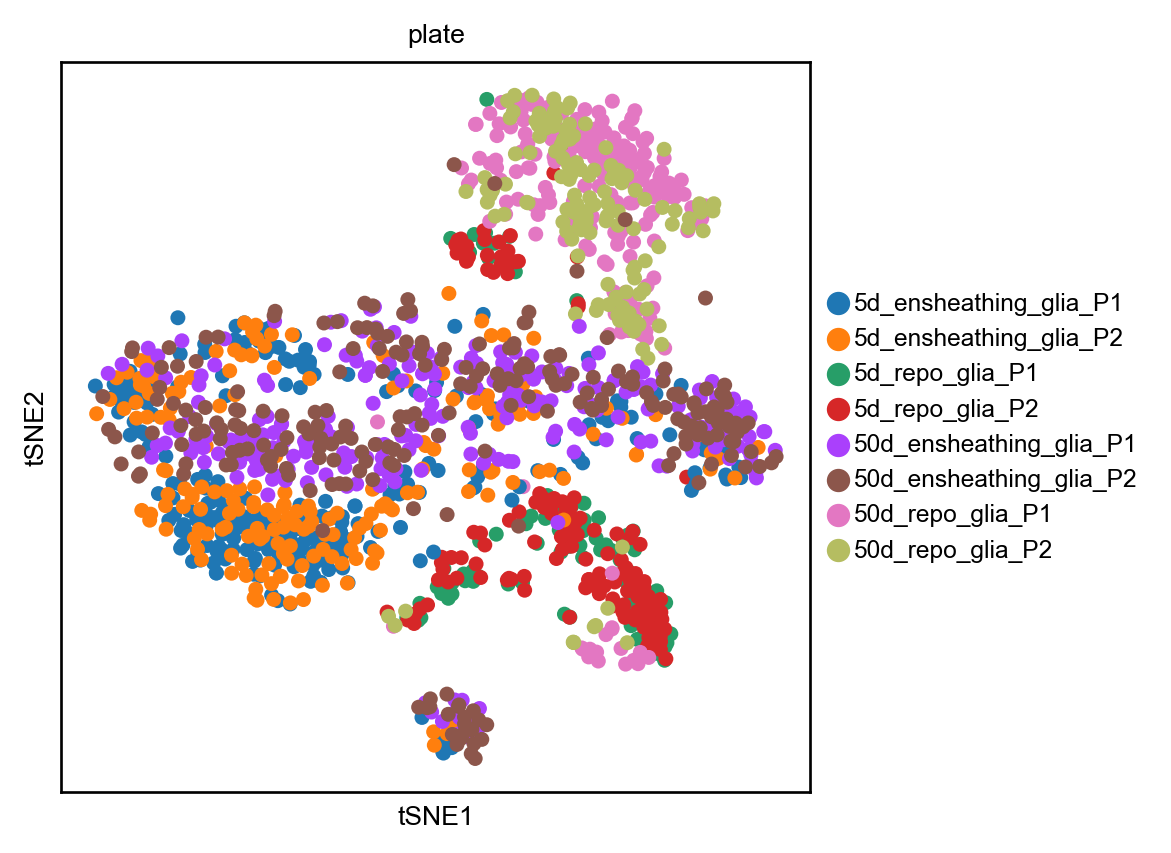

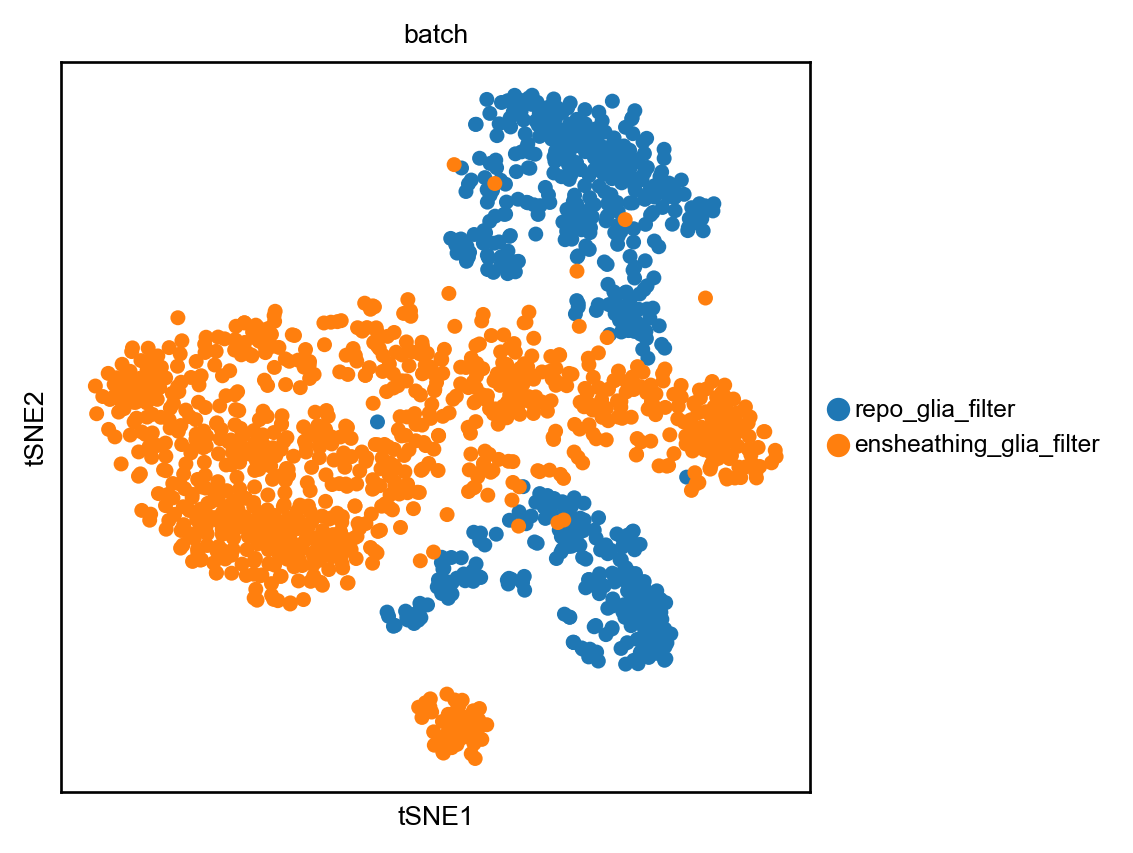

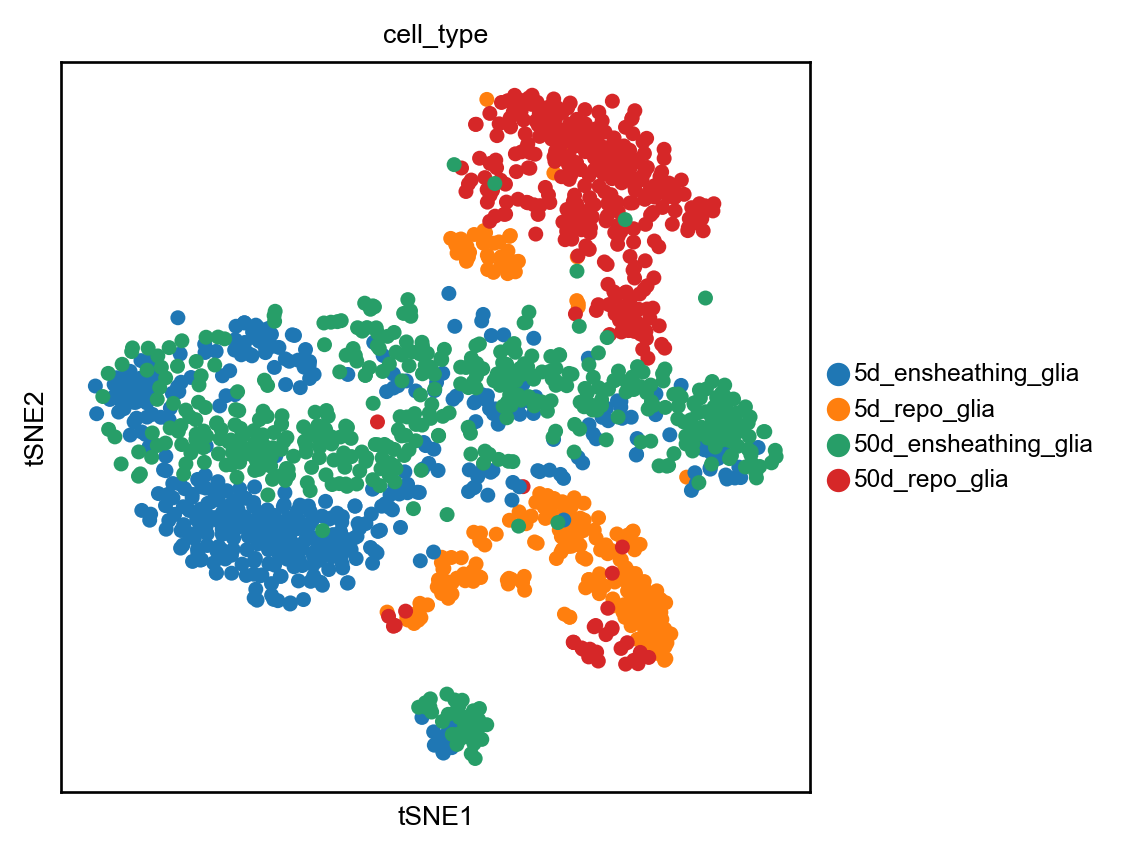

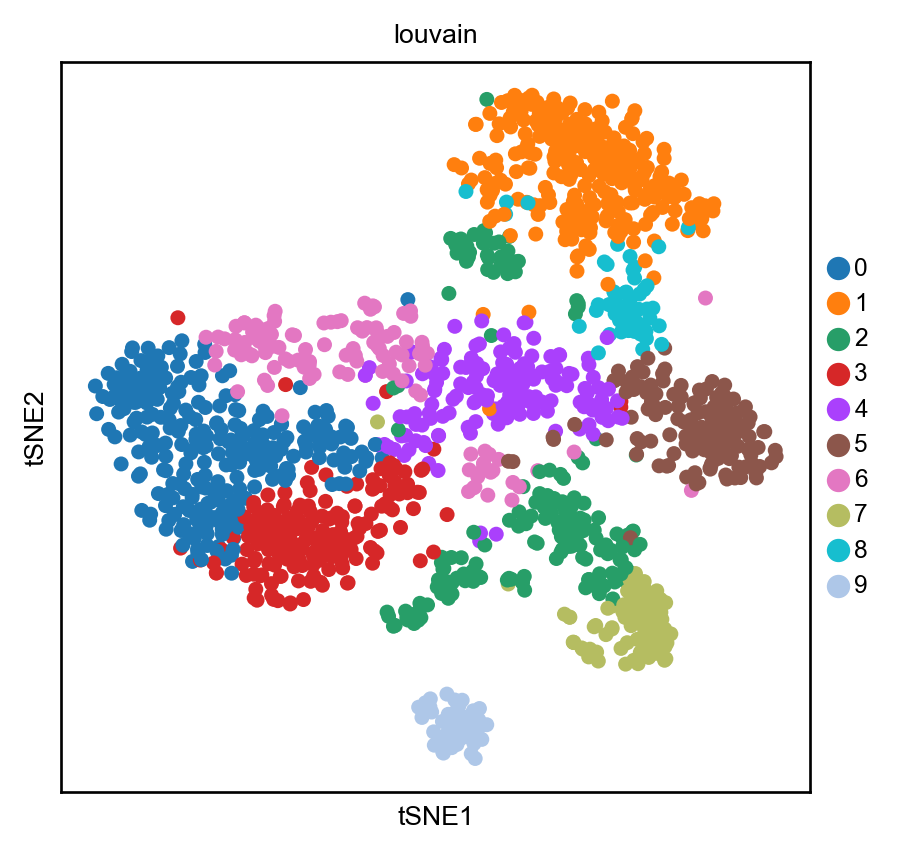

In [54]:
sc.pl.tsne(adata_glia_clean, color="plate",save='all_glia_clean_plate.pdf')
sc.pl.tsne(adata_glia_clean, color="batch",save='all_glia_clean_batch.pdf')
sc.pl.tsne(adata_glia_clean, color="cell_type",save='all_glia_clean_cell_type.pdf')
sc.pl.tsne(adata_glia_clean, color="louvain",save='all_glia_clean_louvain.pdf')

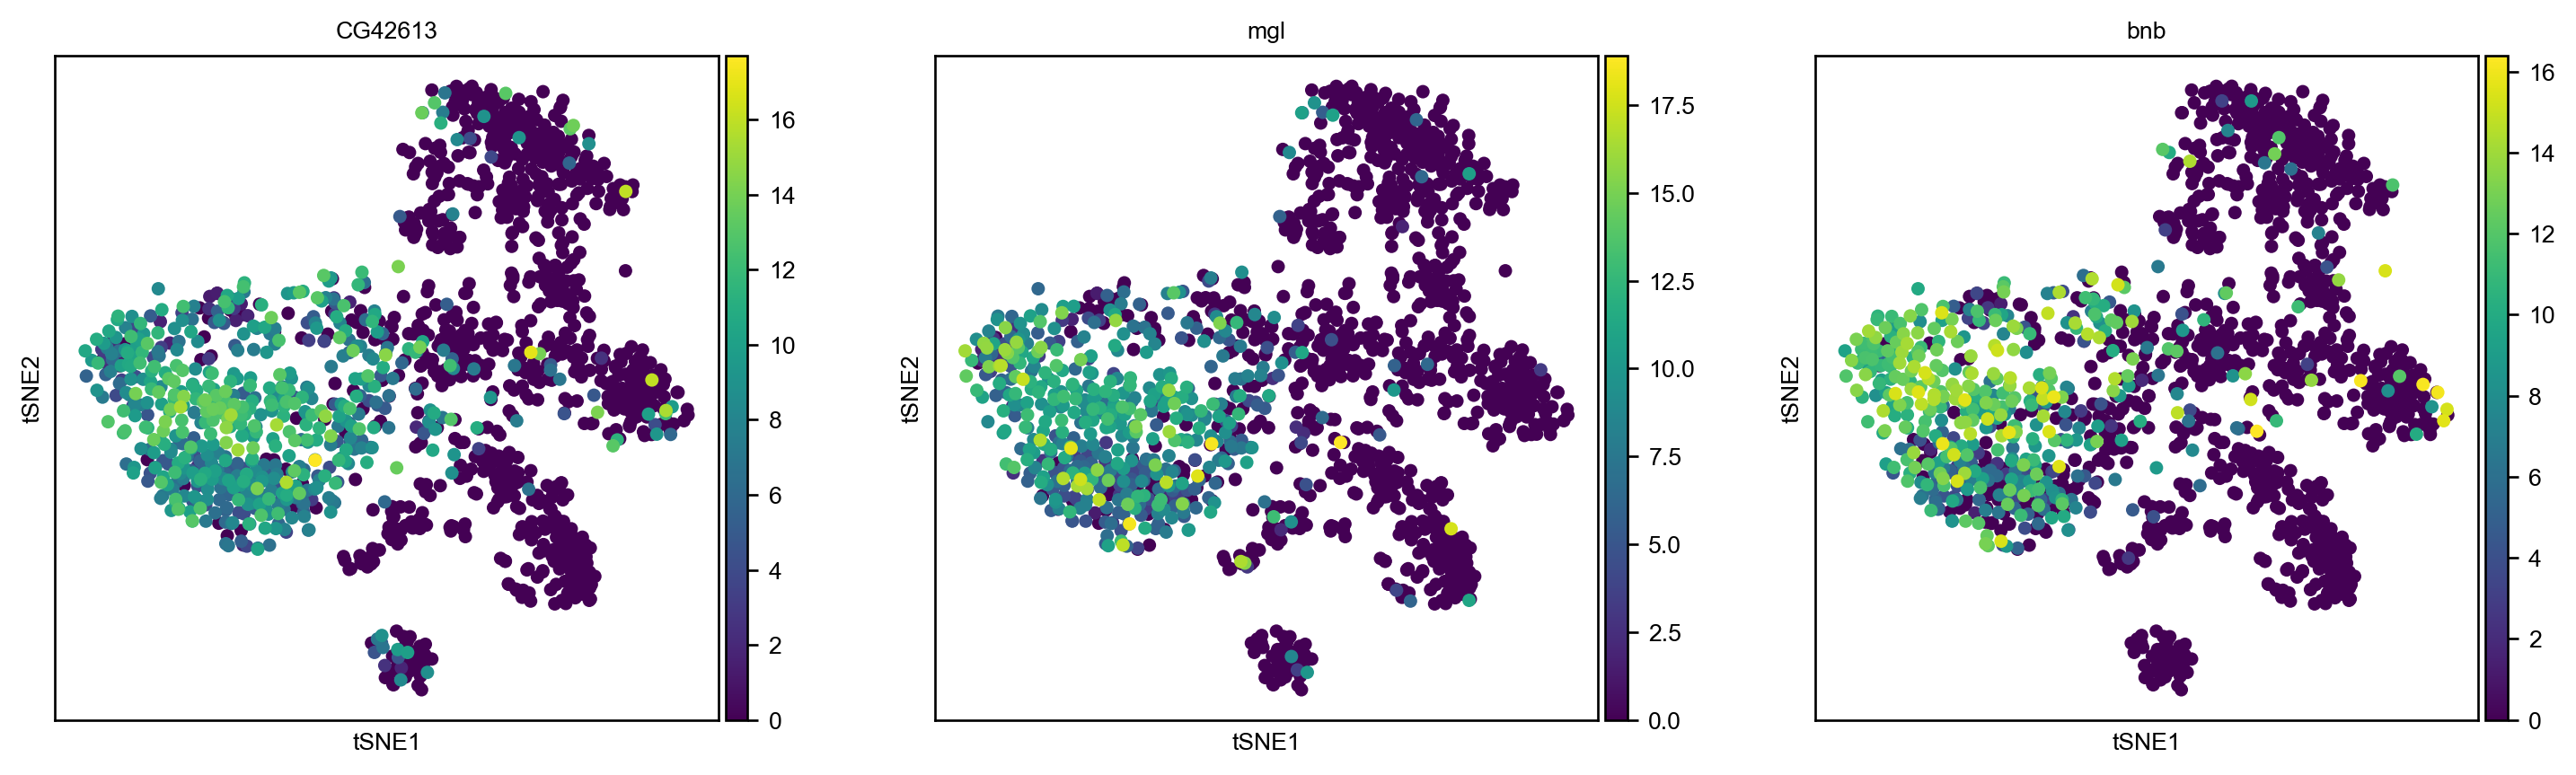

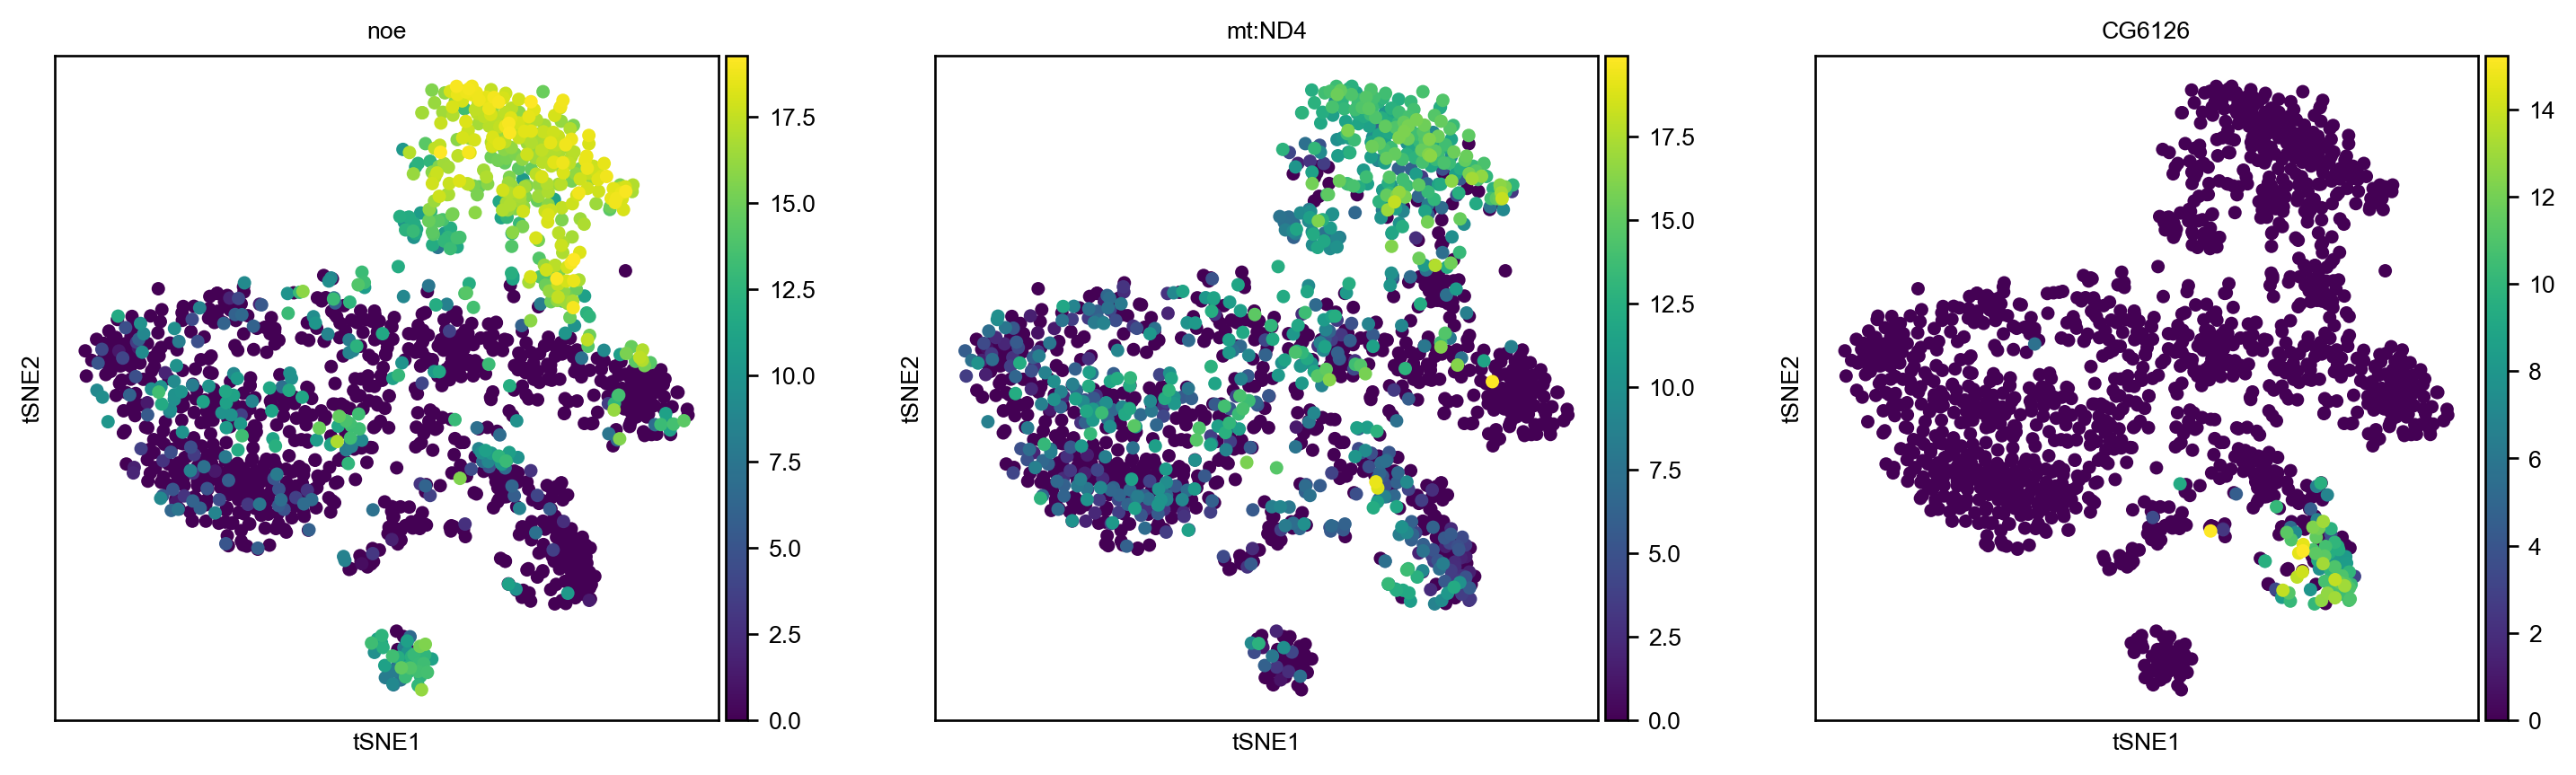

In [56]:
#plot top DE genes
sc.pl.tsne(adata_glia_clean, color=["CG42613","mgl","bnb"])

sc.pl.tsne(adata_glia_clean, color=["noe","mt:ND4","CG6126"])

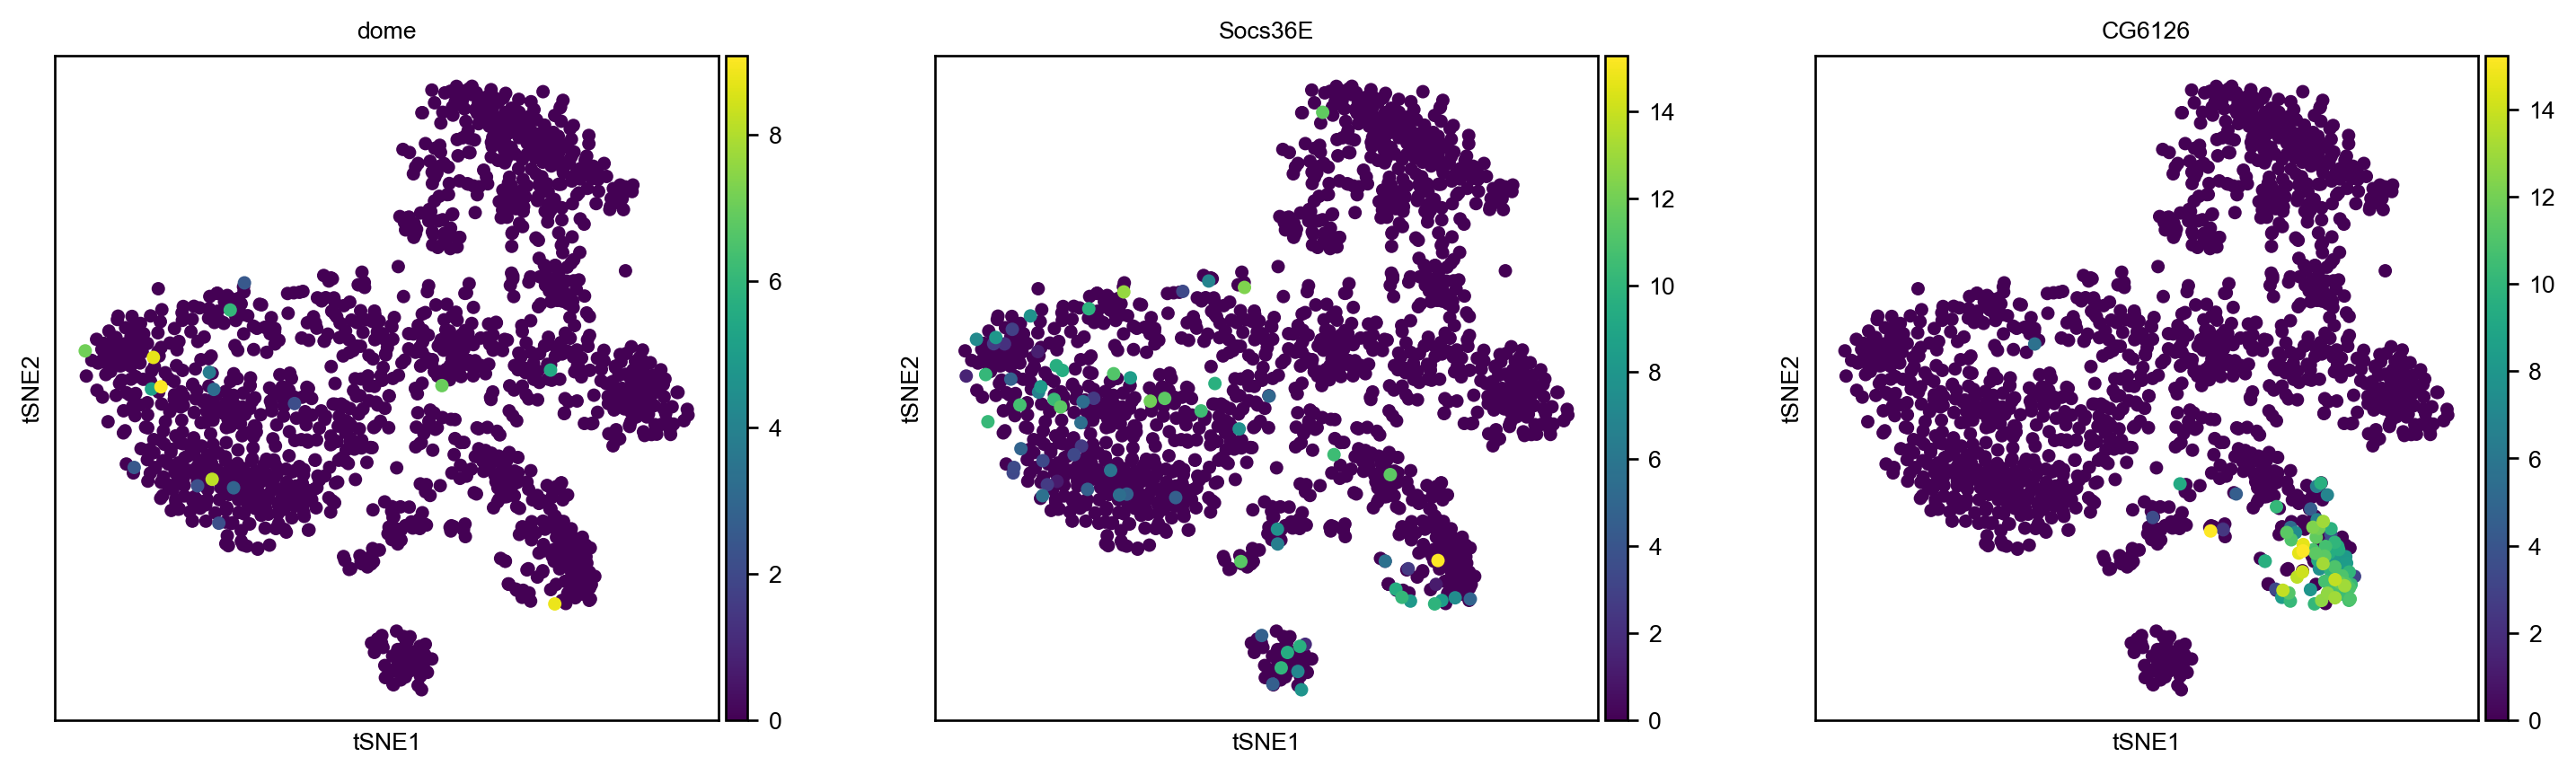

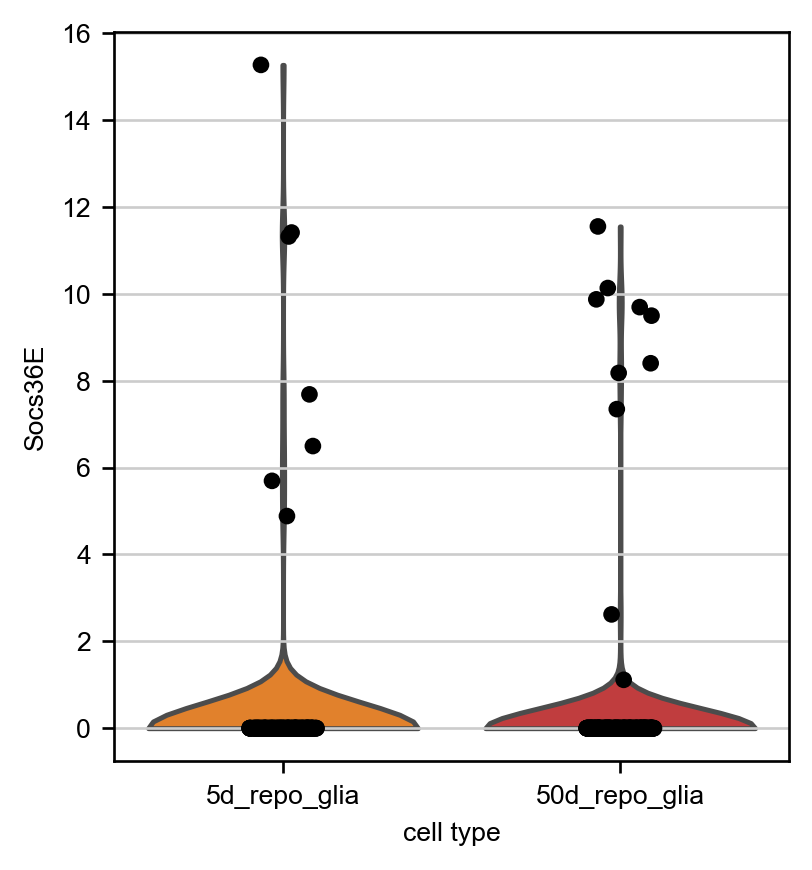

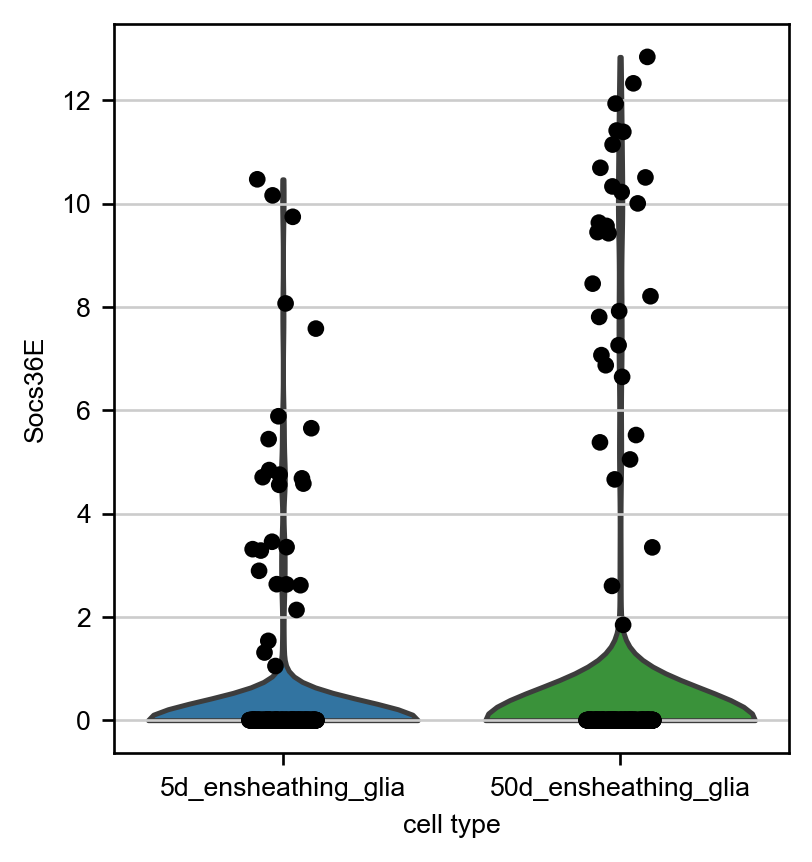

In [59]:
markers=['Socs36E']
sc.pl.violin(adata_repo_glia_nonEn, markers, groupby='cell_type', dendrogram=False, color='r',size=5,
             save='Violin_nonen_glia_Socs36E.pdf')

sc.pl.violin(adata_en_glia_nonRepo, markers, groupby='cell_type', dendrogram=False, color='r',size=5,
             save='Violin_en_glia_Socs36E.pdf')


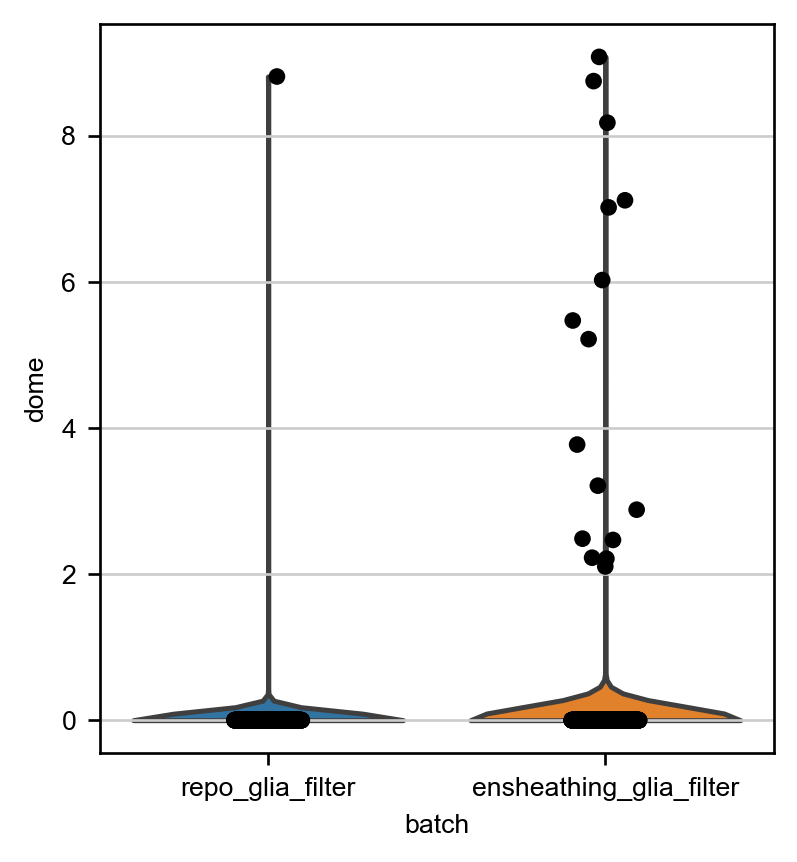

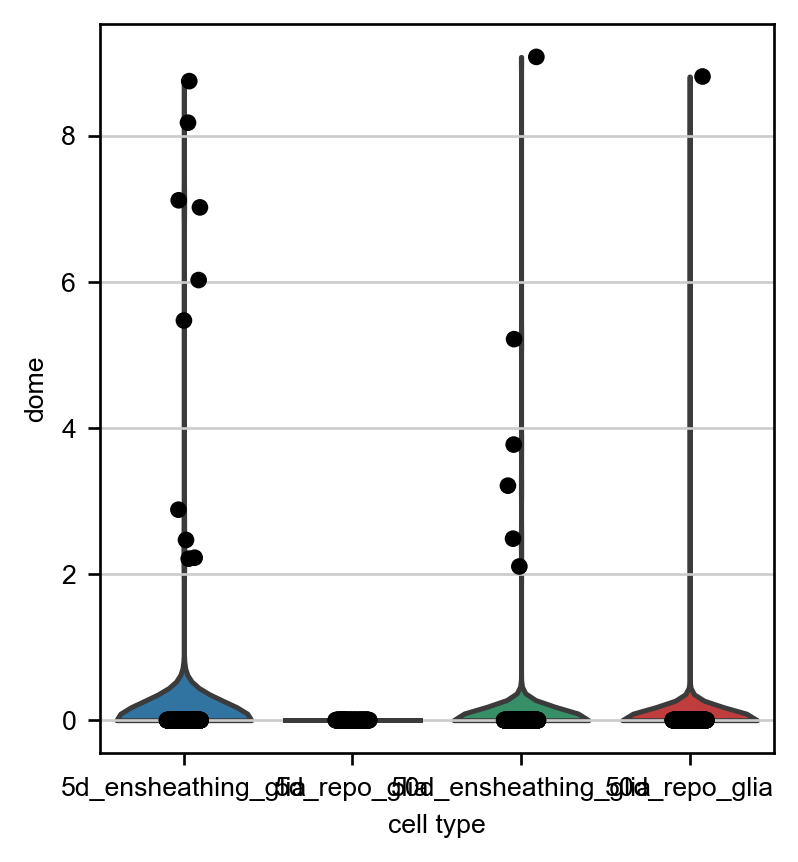

In [60]:
markers=['dome']
sc.pl.violin(adata_glia_clean, markers, groupby='batch', dendrogram=False, color='r',size=5,
            save='Violin_all_glia_dome_batch.pdf')

sc.pl.violin(adata_glia_clean, markers, groupby='cell_type', dendrogram=False, color='r',size=5,
            save='Violin_all_glia_dome_cell_type.pdf')


# data analysis of 57k whole brain scRNAseq data from Aerts lab (Davie et al, 2018 Cell)

In [61]:
adata_brain = sc.read_loom("../data/Aerts_Fly_AdultBrain_Filtered_57k.loom",validate=False)

In [62]:
# add resolution Louvain_2 for extracting glial annotation
clusters = adata_brain.obs['Clusterings']
clusters = [c[0] for c in clusters]

adata_brain.obs['louvain_2'] = pd.Categorical(clusters)

In [63]:
sc.pp.normalize_total(adata_brain)
sc.pp.log1p(adata_brain)

In [64]:
adata_glia_astrocyte = adata_brain[adata_brain.obs['louvain_2']==10] #'astrocyte',

adata_glia_en_1 = adata_brain[adata_brain.obs['louvain_2']==14] #'ensheathing_glia_1',
adata_glia_en_2 = adata_brain[adata_brain.obs['louvain_2']==35] #'ensheathing_glia_2',

adata_glia_en_3 = adata_brain[adata_brain.obs['louvain_2']==60] #'cortex_glia',
adata_glia_en_4 = adata_brain[adata_brain.obs['louvain_2']==66] #'subperineurial_glia_1'
adata_glia_en_5 = adata_brain[adata_brain.obs['louvain_2']==70] #'perineurial_glia',
adata_glia_en_6 = adata_brain[adata_brain.obs['louvain_2']==82] #'Chiasm_glia'
adata_glia_en_7 = adata_brain[adata_brain.obs['louvain_2']==85] #'subperineurial_glia_2'

/Users/hongjieli/anaconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [65]:
adata_glia_all = adata_glia_en_1.concatenate(adata_glia_en_2,
                                             adata_glia_astrocyte,
                                             adata_glia_en_3,
                                             adata_glia_en_5,
                                             adata_glia_en_6,
                                             adata_glia_en_4,
                                             adata_glia_en_7,
                                              batch_categories=['ensheathing_glia_1',
                                                                'ensheathing_glia_2',
                                                                'astrocyte',
                                                                'cortex_glia',
                                                                'perineurial_glia',
                                                                'Chiasm_glia',
                                                                'subperineurial_glia_1',
                                                                'subperineurial_glia_2'])

adata_glia_all

AnnData object with n_obs × n_vars = 3743 × 17473
    obs: 'Age', 'Clusterings', 'Embedding', 'Embeddings_X', 'Embeddings_Y', 'Gender', 'Genotype', 'RegulonsAUC', 'Replicate', 'nGene', 'nUMI', 'louvain_2', 'batch'
    var: 'ClusterMarkers_0', 'ClusterMarkers_0_sub_0', 'ClusterMarkers_0_sub_1', 'ClusterMarkers_0_sub_10', 'ClusterMarkers_0_sub_11', 'ClusterMarkers_0_sub_12', 'ClusterMarkers_0_sub_13', 'ClusterMarkers_0_sub_14', 'ClusterMarkers_0_sub_15', 'ClusterMarkers_0_sub_16', 'ClusterMarkers_0_sub_17', 'ClusterMarkers_0_sub_18', 'ClusterMarkers_0_sub_19', 'ClusterMarkers_0_sub_2', 'ClusterMarkers_0_sub_20', 'ClusterMarkers_0_sub_21', 'ClusterMarkers_0_sub_22', 'ClusterMarkers_0_sub_23', 'ClusterMarkers_0_sub_24', 'ClusterMarkers_0_sub_25', 'ClusterMarkers_0_sub_26', 'ClusterMarkers_0_sub_27', 'ClusterMarkers_0_sub_28', 'ClusterMarkers_0_sub_29', 'ClusterMarkers_0_sub_3', 'ClusterMarkers_0_sub_30', 'ClusterMarkers_0_sub_31', 'ClusterMarkers_0_sub_32', 'ClusterMarkers_0_sub_33', 'Clus

In [66]:
adata_nonEnGlia = adata_glia_astrocyte.concatenate(adata_glia_en_3, 
                                                  adata_glia_en_4,
                                                  adata_glia_en_5,
                                                  adata_glia_en_6,
                                                  adata_glia_en_7,
                                                  batch_categories=['astrocyte', 
                                                                   'cortex_glia',
                                                                   'subperineurial_glia_1',
                                                                    'perineurial_glia',
                                                                   'Chiasm_glia',
                                                                   'subperineurial_glia_2'])

In [72]:
adata_glia_ensheathing = adata_glia_en_1.concatenate(adata_glia_en_2,
                                                  batch_categories=['ensheathing_glia_1',
                                                                    'ensheathing_glia_2'])

In [67]:
sc.tl.pca(adata_glia_all, svd_solver='arpack')

sc.pp.neighbors(adata_glia_all, n_neighbors=15, n_pcs=50)

sc.tl.umap(adata_glia_all)
sc.tl.tsne(adata_glia_all)

sc.tl.louvain(adata_glia_all)

In [68]:
sc.set_figure_params(scanpy=True, dpi=120, dpi_save=300, 
                     frameon=True, vector_friendly=True, fontsize=8, 
                     figsize=None, color_map=None, format='pdf', facecolor=None, 
                     transparent=False, ipython_format='png2x')

/Users/hongjieli/anaconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'Age' as categorical
... storing 'Clusterings' as categorical
... storing 'Gender' as categorical
... storing 'Genotype' as categorical
... storing 'Replicate' as categorical
... storing 'ClusterMarkers_0' as categorical
... storing 'ClusterMarkers_0_sub_0' as categorical
... storing 'ClusterMarkers_0_sub_1' as categorical
... storing 'ClusterMarkers_0_sub_10' as categorical
... storing 'ClusterMarkers_0_sub_11' as categorical
... storing 'ClusterMarkers_0_sub_12' as categorical
... storing 'ClusterMarkers_0_sub_13' as categorical
... storing 'ClusterMarkers_0_sub_14' as categorical
... storing 'ClusterMarkers_0_sub_15' as categorical
... storing 'ClusterMarkers_0_sub_16' as categorical
... storing 'Cl

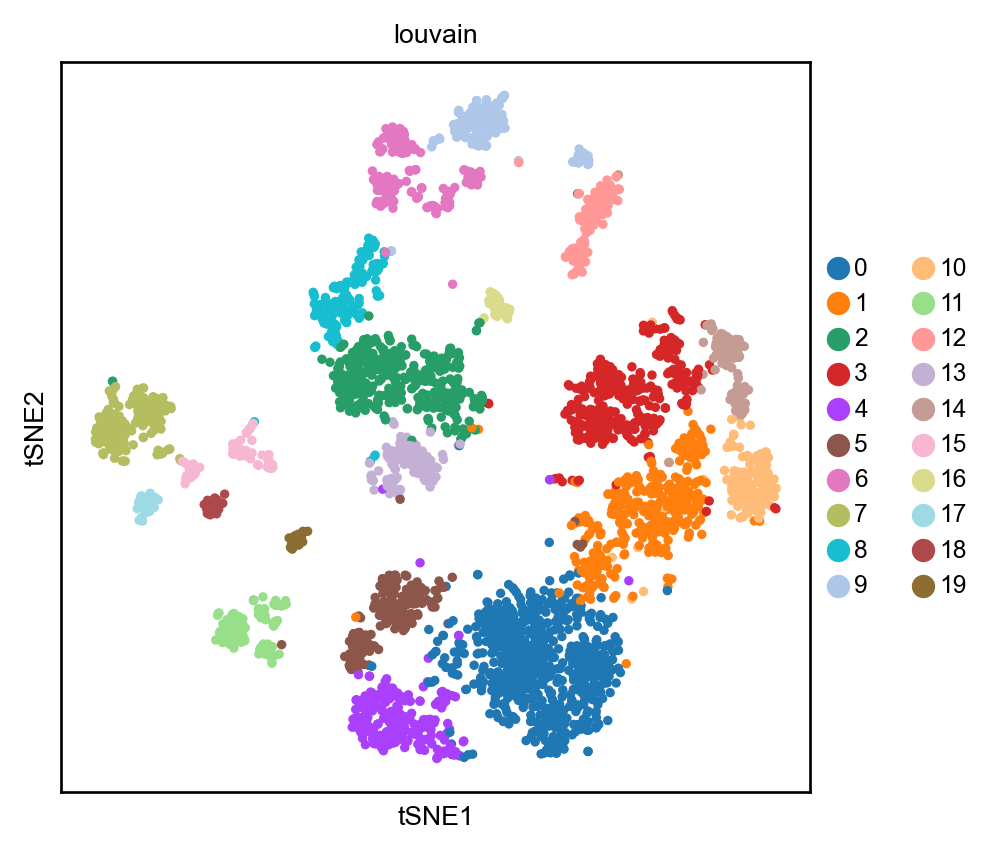

/Users/hongjieli/anaconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


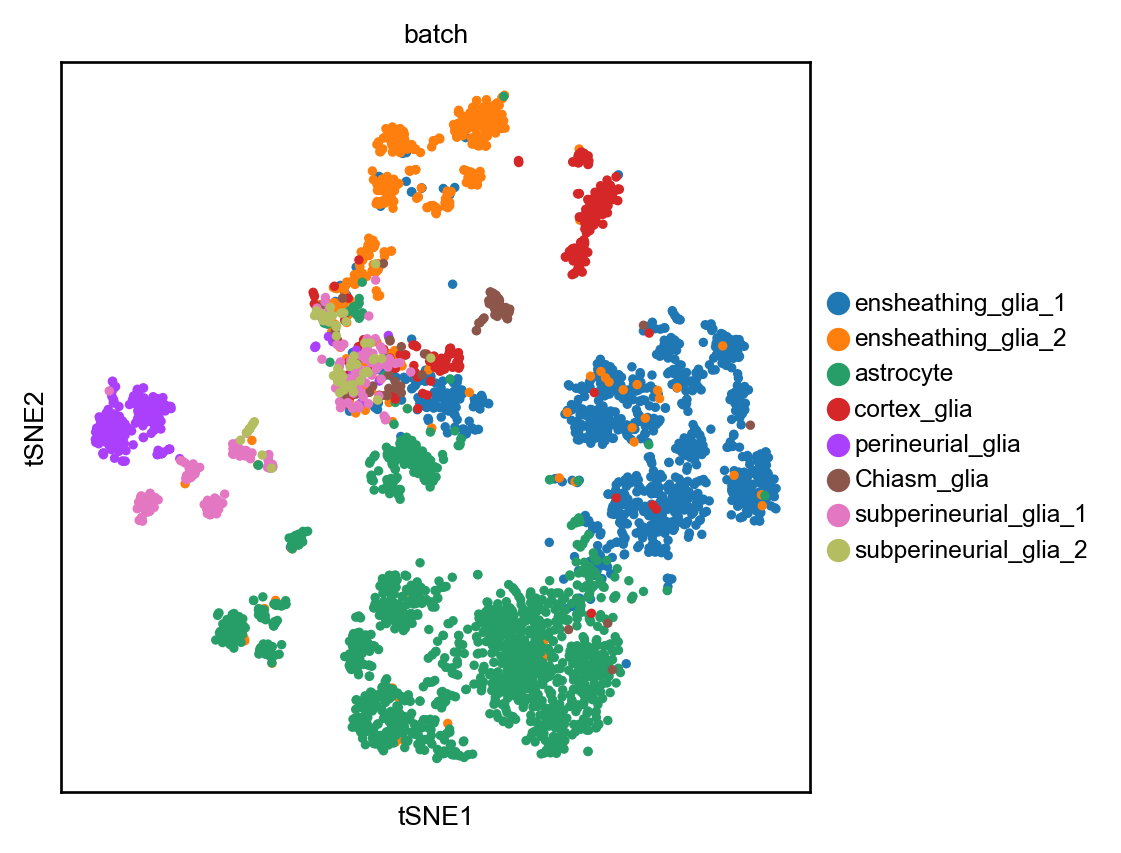

/Users/hongjieli/anaconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


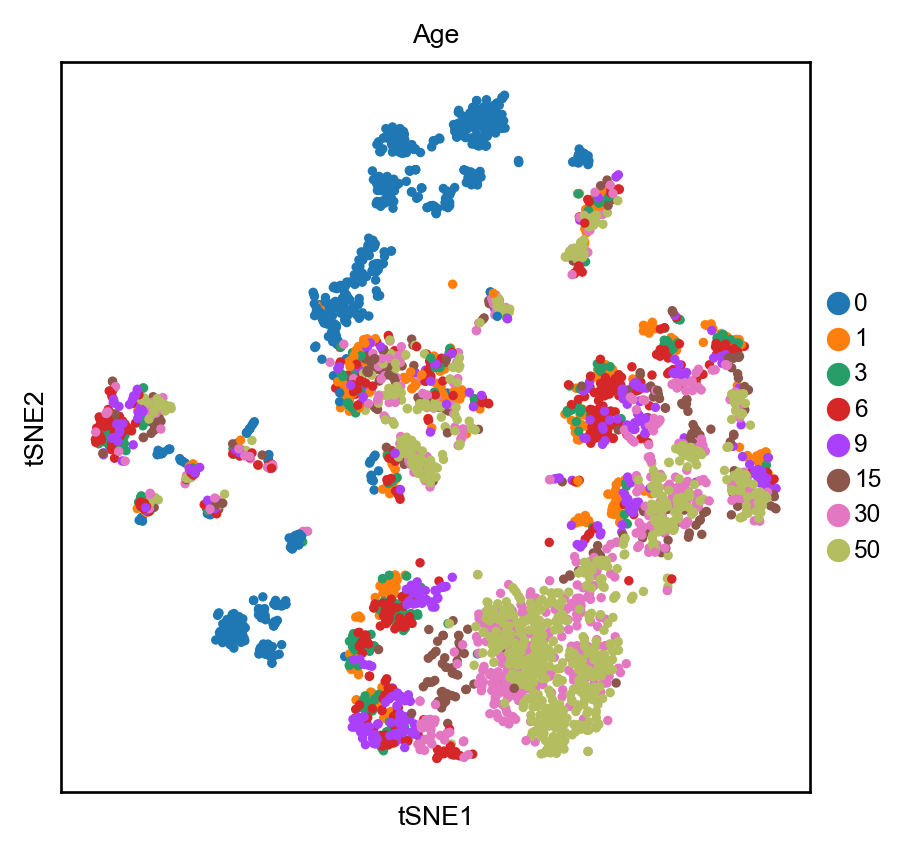

In [69]:
sc.pl.tsne(adata_glia_all, color=["louvain"],save='Davie_all_glia_louvain.pdf')
sc.pl.tsne(adata_glia_all, color=["batch"],save='Davie_all_glia_cell_type.pdf')
sc.pl.tsne(adata_glia_all, color=["Age"],save='Davie_all_glia_Age.pdf')

/Users/hongjieli/anaconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


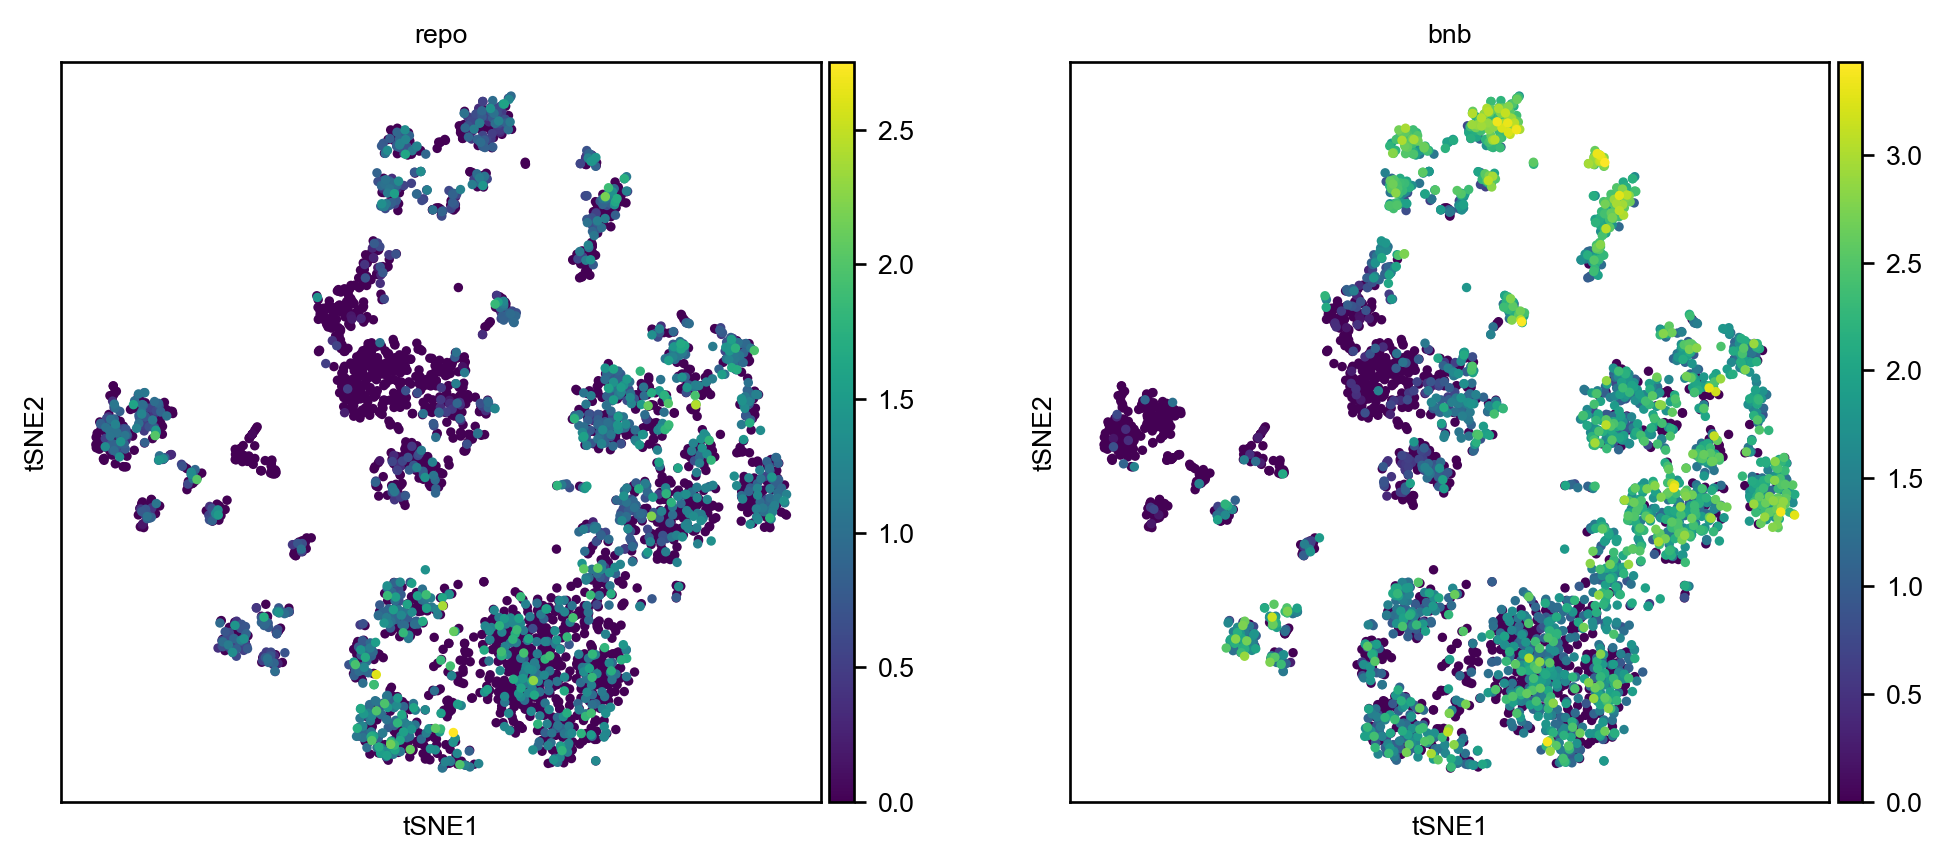

In [81]:
# check ensheathign glia markers
sc.pl.tsne(adata_glia_all, color=["repo","bnb"])

... storing 'Age' as categorical
... storing 'Clusterings' as categorical
... storing 'Gender' as categorical
... storing 'Genotype' as categorical
... storing 'Replicate' as categorical
... storing 'ClusterMarkers_0' as categorical
... storing 'ClusterMarkers_0_sub_0' as categorical
... storing 'ClusterMarkers_0_sub_1' as categorical
... storing 'ClusterMarkers_0_sub_10' as categorical
... storing 'ClusterMarkers_0_sub_11' as categorical
... storing 'ClusterMarkers_0_sub_12' as categorical
... storing 'ClusterMarkers_0_sub_13' as categorical
... storing 'ClusterMarkers_0_sub_14' as categorical
... storing 'ClusterMarkers_0_sub_15' as categorical
... storing 'ClusterMarkers_0_sub_16' as categorical
... storing 'ClusterMarkers_0_sub_17' as categorical
... storing 'ClusterMarkers_0_sub_18' as categorical
... storing 'ClusterMarkers_0_sub_19' as categorical
... storing 'ClusterMarkers_0_sub_2' as categorical
... storing 'ClusterMarkers_0_sub_20' as categorical
... storing 'ClusterMarkers_

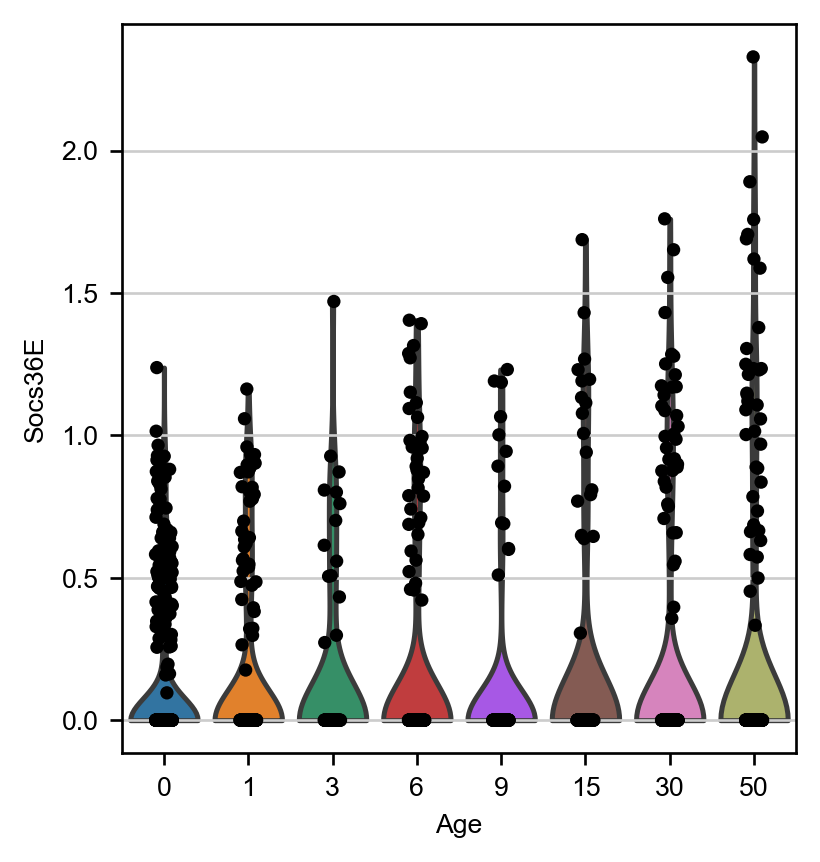

In [73]:
markers=['Socs36E']
sc.pl.violin(adata_glia_ensheathing, markers, groupby='Age', showmeans=True,dendrogram=False, color='1.1',size=4,
            save='Davie_en_glia_Socs36E.pdf')

/Users/hongjieli/anaconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'Age' as categorical
... storing 'Clusterings' as categorical
... storing 'Gender' as categorical
... storing 'Genotype' as categorical
... storing 'Replicate' as categorical
... storing 'ClusterMarkers_0' as categorical
... storing 'ClusterMarkers_0_sub_0' as categorical
... storing 'ClusterMarkers_0_sub_1' as categorical
... storing 'ClusterMarkers_0_sub_10' as categorical
... storing 'ClusterMarkers_0_sub_11' as categorical
... storing 'ClusterMarkers_0_sub_12' as categorical
... storing 'ClusterMarkers_0_sub_13' as categorical
... storing 'ClusterMarkers_0_sub_14' as categorical
... storing 'ClusterMarkers_0_sub_15' as categorical
... storing 'ClusterMarkers_0_sub_16' as categorical
... storing 'Cl

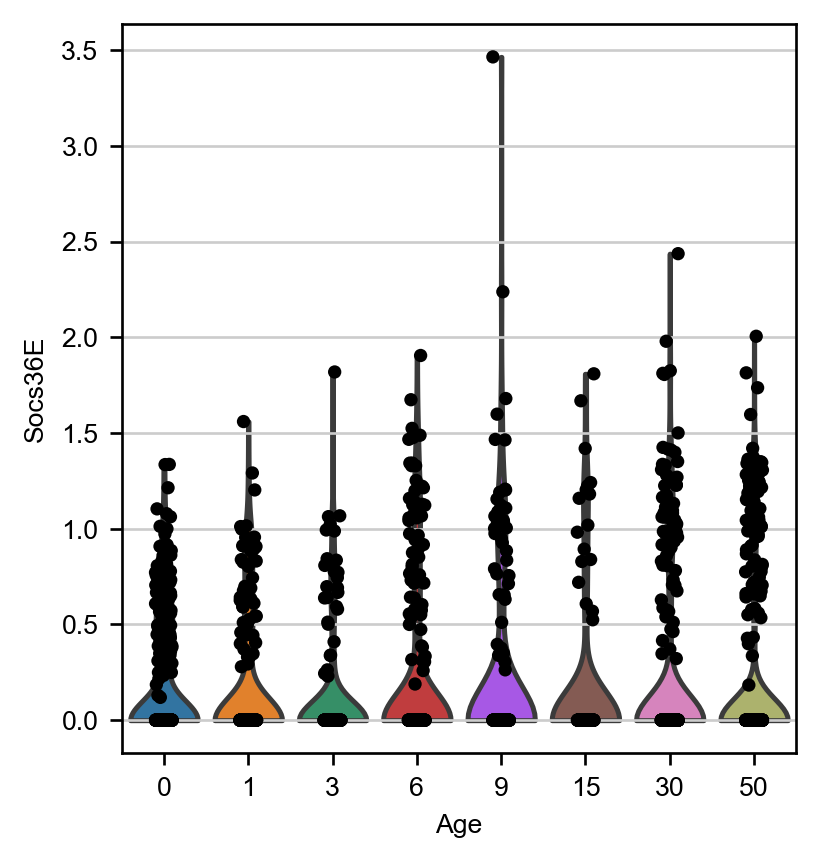

In [74]:
markers=['Socs36E']
sc.pl.violin(adata_nonEnGlia, markers, groupby='Age', showmeans=True,dendrogram=False, color='1.1',size=4,
            save='Davie_nonen_glia_Socs36E.pdf')


In [79]:
#Extract expression values of young and old glia

In [78]:
adata_en_glia_young = adata_glia_ensheathing[(adata_glia_ensheathing.obs["Age"]=="9") | 
                                             (adata_glia_ensheathing.obs["Age"]=="3")|
                                             (adata_glia_ensheathing.obs["Age"]=="6")]

adata_en_glia_old = adata_glia_ensheathing[(adata_glia_ensheathing.obs["Age"]=="50")]

markers=['Socs36E']

x=adata_en_glia_young[:, markers].X
x = x.toarray()
y=adata_en_glia_old[:, markers].X
y = y.toarray()

# print (x)
# print (y)

In [80]:
adata_nonen_glia_young = adata_nonEnGlia[(adata_nonEnGlia.obs["Age"]=="9") | 
                                             (adata_nonEnGlia.obs["Age"]=="3")|
                                             (adata_nonEnGlia.obs["Age"]=="6")]

adata_nonen_glia_old = adata_nonEnGlia[(adata_nonEnGlia.obs["Age"]=="50")]

markers=['Socs36E']

x=adata_nonen_glia_young[:, markers].X
x = x.toarray()
y=adata_nonen_glia_old[:, markers].X
y = y.toarray()

# print (x)
# print (y)